This contains snippets from [Pytorch tutorials](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [28]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import nn

import numpy as np

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import pandas as pd

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



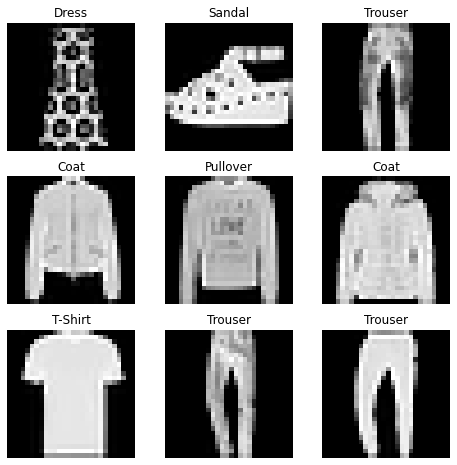

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [5]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


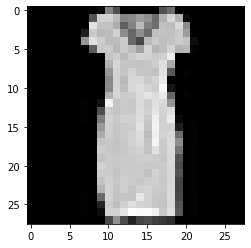

Label: 3


In [12]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [16]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, (3,3))
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(8, 32, (3,3))
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fully_connected = nn.Linear(5 * 5 * 32, 10)

    def forward(self, x):
        # input shape: 28x28x1
        x = self.conv1(x)
        # 26x26x8
        x = self.relu(x)
        x = self.pool(x)
        # 13x13x8
        x = self.conv2(x)
        # 11x11x32
        x = self.relu(x)
        x = self.pool(x)
        # 5x5x32
        x = self.flatten(x)
        x = self.fully_connected(x)

        return x

In [20]:
model = ConvNet().to(device)
print(model)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

ConvNet(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fully_connected): Linear(in_features=800, out_features=10, bias=True)
)


In [21]:
def train_loop(trainloader, testloader, model, loss_fn, optim, epochs):
    size = len(trainloader.dataset)
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}:')
        for batch, (X, y) in enumerate(trainloader):
            output = model(X)
            loss = loss_fn(output, y)

            optim.zero_grad()
            loss.backward()
            optim.step()

            if batch % 100 == 0:
                loss = loss.item()
                print(f'loss: {loss:>7f} [epoch {epoch:>2d}/{epochs:>2d}, sample {batch*len(X):>5d}/{size:>5d}]')

        n_test_batches = len(testloader)
        test_loss = 0.
        with torch.no_grad():
            for X, y in testloader:
                output = model(X)
                test_loss += loss_fn(output, y)
        print(f'Avg test loss: {test_loss/n_test_batches:>7f}\n')


In [22]:
train_loop(train_dataloader, test_dataloader, model, loss_fn, optimizer, 10)

Epoch 1:
loss: 2.300499 [epoch   0/100 sample     0/60000
loss: 0.945121 [epoch   0/100 sample  6400/60000
loss: 0.694573 [epoch   0/100 sample 12800/60000
loss: 0.532534 [epoch   0/100 sample 19200/60000
loss: 0.523727 [epoch   0/100 sample 25600/60000
loss: 0.370995 [epoch   0/100 sample 32000/60000
loss: 0.399286 [epoch   0/100 sample 38400/60000
loss: 0.369628 [epoch   0/100 sample 44800/60000
loss: 0.457447 [epoch   0/100 sample 51200/60000
loss: 0.416225 [epoch   0/100 sample 57600/60000
Avg test loss: 0.465372

Epoch 2:
loss: 0.600909 [epoch   1/100 sample     0/60000
loss: 0.535264 [epoch   1/100 sample  6400/60000
loss: 0.450861 [epoch   1/100 sample 12800/60000
loss: 0.378047 [epoch   1/100 sample 19200/60000
loss: 0.272717 [epoch   1/100 sample 25600/60000
loss: 0.202923 [epoch   1/100 sample 32000/60000
loss: 0.391928 [epoch   1/100 sample 38400/60000
loss: 0.354851 [epoch   1/100 sample 44800/60000
loss: 0.413499 [epoch   1/100 sample 51200/60000
loss: 0.526311 [epoch   1/

KeyboardInterrupt: 

In [24]:
def get_accuracy(model, dataloader):
    n_samples = len(dataloader.dataset)
    n_correct = 0.
    with torch.no_grad():
        for X, y in dataloader:
            output = model(X)
            n_correct += (output.argmax(1) == y).type(torch.float).sum().item()
    return n_correct/n_samples

In [29]:
print(f'Accuracy on train data: {get_accuracy(model, train_dataloader)}')
print(f'Accuracy on test data: {get_accuracy(model, test_dataloader)}')

Accuracy on train data: 0.88525
Accuracy on test data: 0.8763


In [26]:
torch.save(model, 'pytorch_cnn_sample.pth')

In [27]:
model = torch.load('pytorch_cnn_sample.pth')

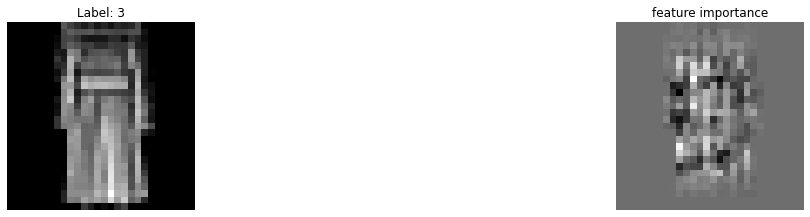

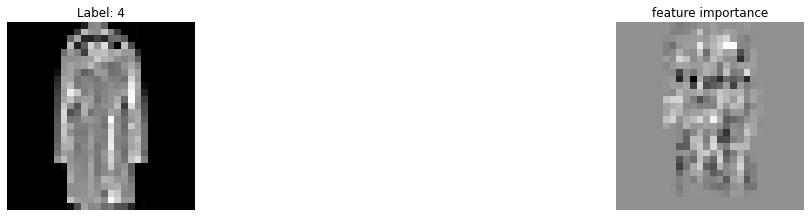

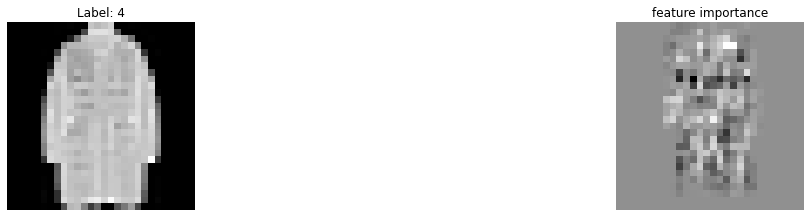

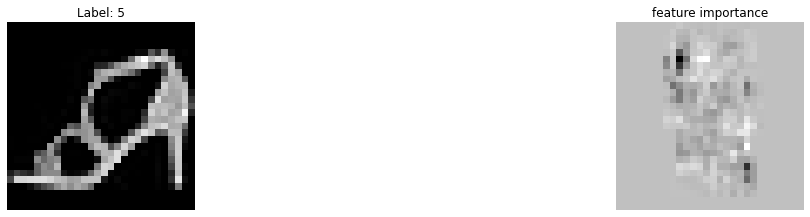

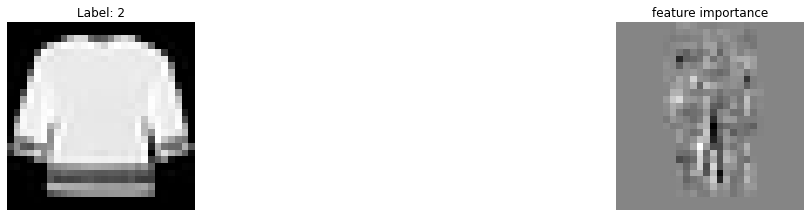

In [61]:
# Captum feature attributions

ig = IntegratedGradients(model)
test_input_tensor, test_labels = next(iter(test_dataloader))
test_input_tensor.requires_grad_()

n_rows = 5
for i in range(n_rows):
    label = test_labels[i].item()
    attr, delta = ig.attribute(test_input_tensor,target=label, return_convergence_delta=True)
    attr = attr.detach().numpy()

    img = test_input_tensor[i][0].detach()
    figure = plt.figure(figsize=(20, 20))
    figure.add_subplot(n_rows, 2, i*2 + 1)
    plt.title(f'Label: {label}')
    plt.axis("off")
    plt.imshow(img, cmap="gray")
    figure.add_subplot(n_rows, 2, i*2 + 2)
    plt.title(f'feature importance')
    plt.axis("off")
    plt.imshow(attr[0][0], cmap="gray")

plt.show()